# 导入依赖包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary,sigmoid,load_planar_dataset,load_extra_datasets

%matplotlib inline
np.random.seed(1)

# 加载数据集

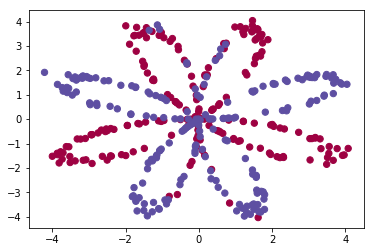

In [2]:
X,Y = load_planar_dataset()
plt.scatter(X[0,:],X[1,:],c=np.squeeze(Y),s=40,cmap=plt.cm.Spectral)

数据看起来像一朵红色（y=0）和蓝色（y=1）的数据点组成的花朵。我们的目标是建立一个模型来适应这些数据。现在，我们已经有了以下东西：
   - X：一个（2，400）的矩阵，包含400个样本点的数值
   - Y：一个（1，400）的矩阵，包含着样本对应的标签【0 | 1】【红色 | 蓝色】

# 看看简单的Logistic回归的分类效果

在构建完整的神经网络之前，先让我们看看逻辑回归在这个问题上的表现如何，我们可以使用sklearn的内置函数来做到这一点， 运行下面的代码来训练数据集上的逻辑回归分类器。

In [3]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X.T,Y.T)

d:\tools\python3.7\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\tools\python3.7\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

逻辑回归的准确性：47%(正确标记的数据点所占百分比)


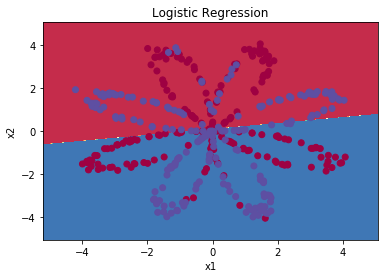

In [4]:
plot_decision_boundary(lambda x: clf.predict(x),X,np.squeeze(Y)) # 绘制决策边界
plt.title('Logistic Regression')
LR_predictions = clf.predict(X.T)
print("逻辑回归的准确性：%d" % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions)) / float(Y.size) * 100) + "%"+"(正确标记的数据点所占百分比)")

准确性只有47%的原因是数据集不是线性可分的，所以线性逻辑回归的表现不佳，现在我们正式开始构建神经网络。

# 搭建神经网络

我们要搭建的神经网络模型如下图：
![神经网络模型图](https://leanote.com/api/file/getImage?fileId=5d89766aab6441211d0013e1)

对于$ x^{(i)} $而言：

$$
\begin{equation}
z^{[1](i)} = W^{[1]}x^{(i)}+b^{[1]}\tag{1}
\end{equation}
$$

$$
\begin{equation}
a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}
\end{equation}
$$

$$
\begin{equation}
z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}
\end{equation}
$$

$$
\begin{equation}
\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}
\end{equation}
$$

$$
\begin{equation}
y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}
\end{equation}
$$

按照如下方式计算成本J：

$$
\begin{equation}
J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}
\end{equation}
$$

构造神经网络的一般方法是：
1. 定义神经网络结构（输入单元的数量，隐藏单元的数量等）
2. 初始化模型的参数
3. 循环
   - 前向传播
   - 计算损失
   - 后向传播
   - 更新参数

我们要把他们糅合到一个nn_model()函数中，当函数学习到正确的参数后，就可以预测新的数据了。

## 定义神经网络结构

在构建前，我们要先把神经网络的结构定义好：
   - n_x:输入层的单元数量
   - n_h:隐藏层的单元数量
   - n_y:输出层的单元数量

In [5]:
def layer_sizes(X,Y):
    '''
    参数：
    X - 输入数据集
    Y - 标签
    
    返回：
    n_x - 输入层单元个数
    n_h - 隐藏层单元个数
    n_y - 输出层单元个数
    '''
    n_x = X.shape[0] 
    n_h = 4
    n_y = Y.shape[0]
    
    return (n_x,n_h,n_y)
    

测试一下layer_sizes函数：

In [6]:
print("===========================测试layer_sizes========================")
X_assess,Y_assess = layer_sizes_test_case();
(n_x,n_h,n_y) = layer_sizes(X_assess,Y_assess)
print("输入层的节点数量为：n_x = "+str(n_x))
print("隐藏层的节点数量为：n_h = "+str(n_h))
print("输出层的节点数量为：n_y = "+str(n_y))

===========================测试layer_sizes========================
输入层的节点数量为：n_x = 5
隐藏层的节点数量为：n_h = 4
输出层的节点数量为：n_y = 2


## 初始化模型参数

在这里，我们要实现函数initialize_parameters()。我们要确保我们的参数大小合适，如果需要的话，请参考上面的神经网络图。
我们将会用随机值初始化权重矩阵，将偏向量矩阵初始化为全0矩阵。

In [7]:
def initialize_parameters(n_x,n_h,n_y):
    """
    参数：
        n_x - 输入层单元个数
        n_h - 隐藏层单元个数
        n_y - 输出层单元个数
        
    返回：
        W1 - 权重矩阵，维度为（n_h,n_x）
        b1 - 偏向量，维度为（n_h,1）
        
        W2 - 权重矩阵，维度为（n_y,n_h）
        b2 - 偏向量，维度为（n_y,1）
    """
    
    np.random.seed(2)
    W1 = np.random.randn(n_h,n_x) * 0.01 # 参数设置大的话，梯度下降会慢
    b1 = np.zeros(shape=(n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros(shape=(n_y,1))
    
    # 使用断言确保数据的维度是正确的
    assert(W1.shape == (n_h,n_x))
    assert(b1.shape == (n_h,1))
    assert(W2.shape == (n_y,n_h))
    assert(b2.shape == (n_y,1))
    
    parameters = {
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2
    }
    
    return parameters

测试一下initialize_parameters函数：

In [8]:
print("=====================测试initialize_parameters函数================")
n_x,n_h,n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x,n_h,n_y)
print("W1="+str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=====================测试initialize_parameters函数================
W1=[[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


## 前向传播

我们现在要实现前向传播函数forward_propagation()。
我们可以使用sigmoid()函数，也可以使用np.tanh()函数。
步骤如下：
  - 使用字典类型的parameters检索每个参数
  - 实现向前传播，计算Z[1]，A[1]，Z[2]和A[2]
  - 反向传播所需要的值存储在“cache”中，cache作为反向传播函数的输入

In [9]:
def forward_propagation(X,parameters):
    """
    参数：
    X - 维度为（n_x,m）
    parameters - 参数
    
    返回：
    A2 - 使用sigmoid函数作为激活函数计算的输出矩阵
    cache - 包含"Z1","A1","Z2","A2"的字典类型变量
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 前向传播计算A2
    Z1 = np.dot(W1,X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    
    # 使用断言判断输出A1的维度
    assert(A2.shape == (1,X.shape[1]))
    
    cache = {
        "Z1":Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    
    return (A2,cache)

测试一下forward_propagation函数：

In [10]:
print("===============测试forward_propagation函数===================")
X_assess,parameters = forward_propagation_test_case()
A2,cache = forward_propagation(X_assess,parameters)
print(np.mean(cache["Z1"]),np.mean(cache["A1"]),np.mean(cache["Z2"]),np.mean(cache["A2"]))

===============测试forward_propagation函数===================
-0.0004997557777419913 -0.0004969633532317802 0.0004381874509591466 0.500109546852431


## 计算损失

计算成本的公式如下：
$$
\begin{equation}
J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}
\end{equation}
$$

In [11]:
def compute_cost(A2,Y):
    """
    计算交叉熵成本
    
    参数：
    A2 - 使用sigmoid激活函数计算出的预测值向量
    Y - 标签数据
    
    返回：
    cost - 成本
    """
    
    m = Y.shape[1]
    
    logprobs = np.multiply(np.log(A2),Y)  + np.multiply(np.log(1-A2),(1-Y))
    cost = -np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
    
    assert(isinstance(cost,float))
    
    return cost

测试一下compute_cost函数：

In [12]:
print("==================测试compute_cost函数=================")
A2,y_assess,parameters = compute_cost_test_case()
print("cost= "+str(compute_cost(A2,y_assess)))

==================测试compute_cost函数=================
cost= 0.6929198937761266


## 后向传播
后向传播的推导过程比较复杂，这里直接给出公式。其中为了计算dZ[1],我们要求g[1]'(Z[1])

这里的g(Z[1])是参数为Z[1]的tanh激活函数。关于tanh的求导参考[https://www.cnblogs.com/CZiFan/p/9853013.html](https://www.cnblogs.com/CZiFan/p/9853013.html)

$$
\begin{equation}
g^{[1]'}(z^{[1]}) = 1 - (A^{[1]})^2
\end{equation}
$$

![后向传播](https://leanote.com/api/file/getImage?fileId=5d9e8999ab64415a4900078f)

In [13]:
def backward_propagation(parameters,cache,X,Y):
    """
    反向传播函数
    
    参数：
        parameters - 包含权重向量和偏置向量的参数字典
        cache - 包含“Z1”,"A1","Z2","A2"的参数字典
        X - 输入数据
        Y - 标签
        
    返回：
        grads - 包含W和b的倒数的字典变量
    """
    
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2,A1.T)
    db2 = (1 / m) * np.sum(dZ2,axis=1,keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T,dZ2),1-np.power(A1,2))
    dW1 = (1 / m) * np.dot(dZ1,X.T)
    db1 = (1 / m) * np.sum(dZ1,axis=1,keepdims=True)
    
    grads = {
        "dW1":dW1,
        "db1":db1,
        "dW2":dW2,
        "db2":db2
    }
    
    return grads

测试一下反向传播函数：

In [14]:
print("===================测试backward_propagation===============")
parameters,cache,X_assess,Y_assess = backward_propagation_test_case()
grads = backward_propagation(parameters,cache,X_assess,Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

===================测试backward_propagation===============
dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


## 更新参数

我们需要使用（dW1，db1，dW2，db2）来更新（W1，b1，W2，b2）。

我们需要选择一个较好的学习率$\alpha$，良好的学习率对于函数收敛具有重要意义。我们可以看看下面的两幅图：

![](https://leanote.com/api/file/getImage?fileId=5d9e94fdab64415a4900080c)
![](https://leanote.com/api/file/getImage?fileId=5d9e94d2ab64415c470007ef)

In [15]:
def update_parameters(parameters,grads,learning_rate=1.2):
    """
    使用上面给出的梯度下降更新规则更新参数

    参数：
     parameters - 包含参数的字典类型的变量。
     grads - 包含导数值的字典类型的变量。
     learning_rate - 学习速率

    返回：
     parameters - 包含更新参数的字典类型的变量。
    """
    W1,W2 = parameters["W1"],parameters["W2"]
    b1,b2 = parameters["b1"],parameters["b2"]

    dW1,dW2 = grads["dW1"],grads["dW2"]
    db1,db2 = grads["db1"],grads["db2"]

    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters

测试一下update_parameters：

In [16]:
print("================测试update_parameters===============")
parameters,grads = update_parameters_test_case()
parameters = update_parameters(parameters,grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

================测试update_parameters===============
W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


# 整合

我们现在将上面的步骤整合到nn_model中。

In [27]:
def nn_model(X,Y,n_h,num_iterations,print_cost=False):
    """
    参数：
        X - 数据集
        Y - 标签
        n_h - 隐藏层单元个数
        num_iterationsum - 梯度下降迭代次数
        print_cost - 如果设置为True，则每1000次迭代打印一次成本值
        
    返回：
        parameters - 模型学得的参数
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X,Y)[0]
    n_y = layer_sizes(X,Y)[2]
    
    parameters = initialize_parameters(n_x,n_h,n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(num_iterations):
        A2,cache = forward_propagation(X,parameters)
        cost = compute_cost(A2,Y)
        grads = backward_propagation(parameters,cache,X,Y)
        parameters = update_parameters(parameters,grads,learning_rate=1.2)
        
        if i % 1000 == 0 and print_cost:
            print("在第",i,"次迭代后，代价为："+str(cost))
            
        
#         print("在第",i,"次迭代后，代价为："+str(cost))
            
    return parameters

测试nn_model():

In [28]:
print("=========================测试nn_model=========================")
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess,Y_assess,4,num_iterations=10000,print_cost=False)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

=========================测试nn_model=========================


d:\tools\python3.7\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
E:\Code\DeepLearning\dl-exercise\神经网络和深度学习\Week 3 - PA 2 - Planar data classification with one hidden layer\planar_utils.py:25: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


W1 = [[-4.18503221  5.33202068]
 [-7.53804031  1.20755589]
 [-4.19293977  5.32619812]
 [ 7.53799615 -1.20758084]]
b1 = [[ 2.32933849]
 [ 3.8100126 ]
 [ 2.33010276]
 [-3.81008759]]
W2 = [[-6033.82350033 -6008.14291323 -6033.0877268   6008.0793796 ]]
b2 = [[-52.67929251]]


# 预测

构建predict()来使用模型进行预测， 使用向前传播来预测结果。

$$
\begin{equation}
predictions=y_{预测} = \begin{cases}   
      1 & 激活值> 0.5 \\  
      0 & \text{其他}  
    \end{cases}
\end{equation}
$$

In [31]:
def predict(parameters,X):
    """
    使用学习的参数，为X中的每一个示例预测一个分类
    
    参数：
        parameters - 参数
        X - 输入数据
        
    返回：
        predictions - 预测值
"""
    A2,cache = forward_propagation(X,parameters)
    predictions = np.round(A2)
    
    return predictions

测试一下predict():

In [32]:
print("=========================测试predict=========================")

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("预测的平均值 = " + str(np.mean(predictions)))

=========================测试predict=========================
预测的平均值 = 0.6666666666666666


# 正式运行

在第 0 次迭代后，代价为：0.6930480201239823
在第 1000 次迭代后，代价为：0.2880832935690184
在第 2000 次迭代后，代价为：0.254385494073245
在第 3000 次迭代后，代价为：0.23386415038952196
在第 4000 次迭代后，代价为：0.2267924874485401
在第 5000 次迭代后，代价为：0.22264427549299015
在第 6000 次迭代后，代价为：0.21973140404281324
在第 7000 次迭代后，代价为：0.21750365405131297
在第 8000 次迭代后，代价为：0.2194395703629519
在第 9000 次迭代后，代价为：0.21855345408675017
准确率：90%


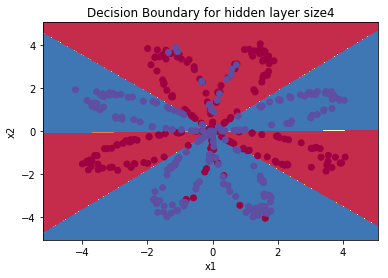

In [39]:
parameters = nn_model(X,Y,n_h=4,num_iterations=10000,print_cost=True)

# 绘制边界
plot_decision_boundary(lambda x: predict(parameters,x.T),X,np.squeeze(Y))
plt.title("Decision Boundary for hidden layer size" + str(4))

predictions = predict(parameters,X)
print('准确率：%d' % float((np.dot(Y,predictions.T)+np.dot(1-Y,1-predictions.T)) / float(Y.size)*100) + '%')

# 更改隐藏层节点数量

我们上面的实验把隐藏层定为4个节点，现在我们更改隐藏层里面的节点数量，看一看节点数量是否会对结果造成影响。

隐藏层的节点数量：1，准确率：67.5 %
隐藏层的节点数量：2，准确率：67.25 %
隐藏层的节点数量：3，准确率：90.75 %
隐藏层的节点数量：4，准确率：90.5 %
隐藏层的节点数量：5，准确率：91.25 %
隐藏层的节点数量：20，准确率：90.5 %
隐藏层的节点数量：50，准确率：90.25 %


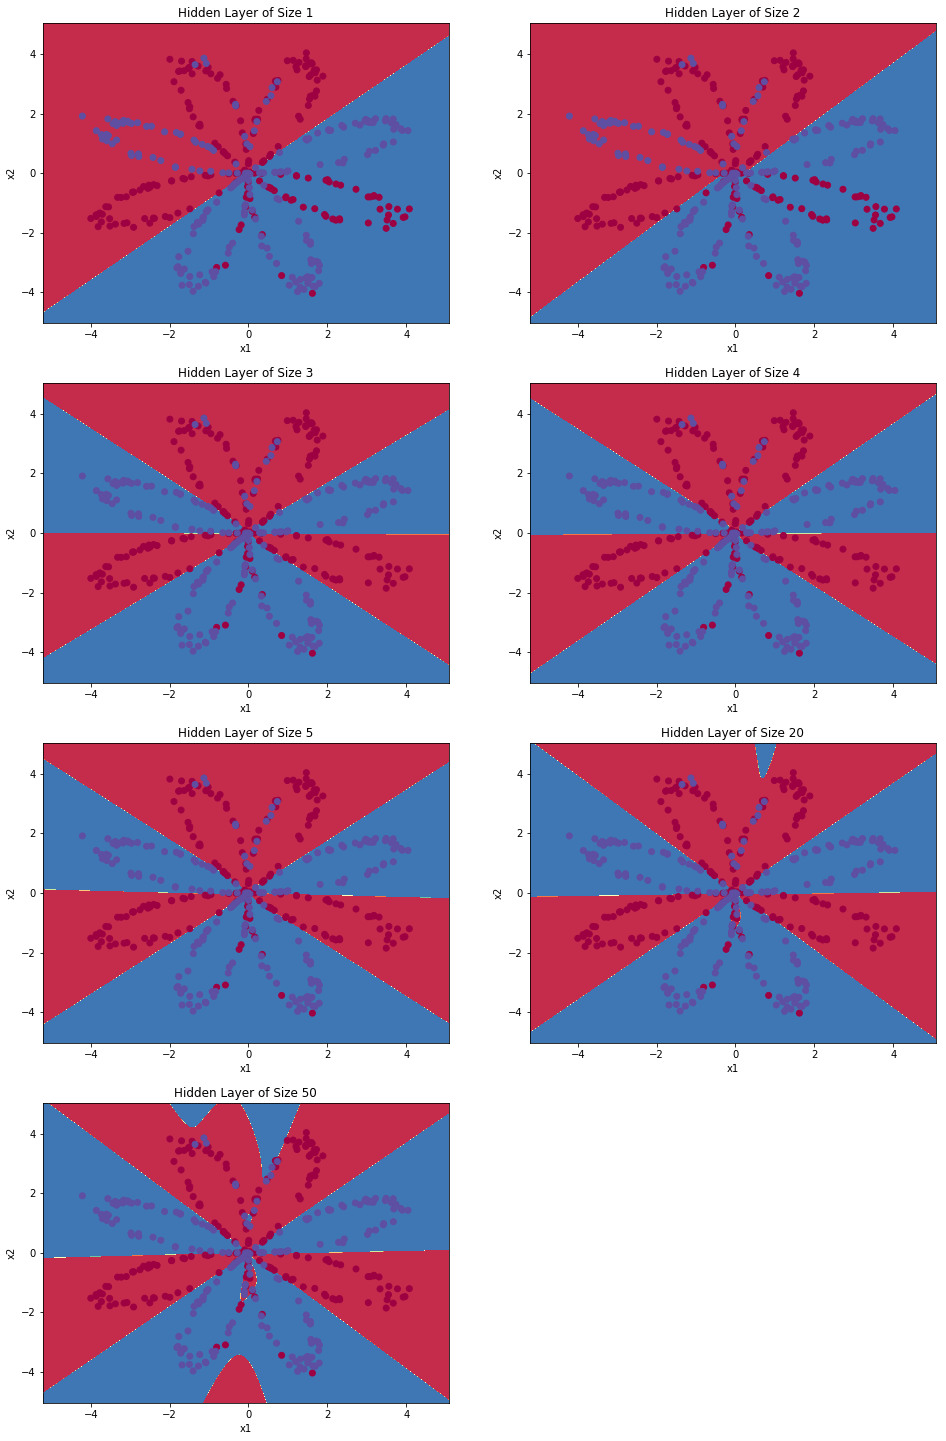

In [43]:
plt.figure(figsize=(16,32))
hidden_layer_sizes = [1,2,3,4,5,20,50]
for i,n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5,2,i+1)
    plt.title("Hidden Layer of Size %d" % n_h)
    parameters = nn_model(X,Y,n_h,num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters,x.T),X,np.squeeze(Y))
    predictions = predict(parameters,X)
    accuracy = float((np.dot(Y,predictions.T)+np.dot(1-Y,1-predictions.T)) / float(Y.size) * 100)
    print("隐藏层的节点数量：{}，准确率：{} %".format(n_h,accuracy))

较大的模型（具有更多隐藏单元）能够更好地适应训练集，直到最终的最大模型过度拟合数据。
最好的隐藏层大小似乎在n_h = 5附近。实际上，这里的值似乎很适合数据，而且不会引起过度拟合。

# 遗留问题

    1.决策边界的画法
    2.测试nn_model对于生成的小样本数据，始终无法收敛，无论是改变学习率和迭代轮数都无效